# Preludio

In [1]:
%matplotlib inline
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision(X, y, clf, title='Decision Surface', **params):
    X = np.array(X)
    y = np.array(y)
    ax = plt.gca()
    
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('X0')
    ax.set_ylabel('X1')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

# AND

Para comenzar, entrenamos un clasificador para resolver el problema del AND. Esto es un caso realmente muy simple, que sólo sirve para que vean cómo se entrena.

En cada caso, reseteamos el random seed a 0. Esto es para asegurar reproducibilidad de los resultados. Si no, podríamos tener corridas con distinta salida sólo por el hecho de que durante el entrenamiento se toman decisiones aleatorias. ¿Por qué hay generación de números aleatorios? porque la implementación por debajo hace ciertas cosas para feature selection.

In [3]:
X = [[1, 1],
     [1, 0],
     [0, 1],
     [0, 0]]
y = [1, 0, 0, 0]

np.random.seed(0)
clf = svm.LinearSVC()
clf.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

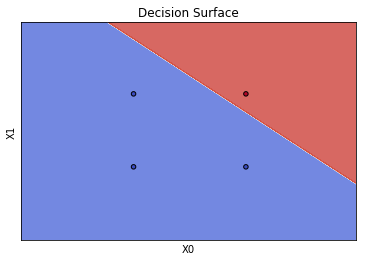

In [4]:
plot_decision(X, y, clf)

# XOR

Para este caso, elegimos el problema del XOR. Este es un caso famoso porque es sabido que no se puede resolver con un clasificador lineal (lo cual es obvio mirando a los puntos que deseamos clasificar). 

En efecto, lo mejor que logramos es clasificar a 3 de los 4 puntos bien.

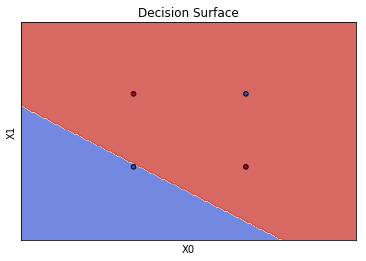

In [5]:
X = [[1, 1],
     [1, 0],
     [0, 1],
     [0, 0]]
y = [0, 1, 1, 0]

np.random.seed(0)
clf = svm.LinearSVC(C=1000)
clf.fit(X, y)
plot_decision(X, y, clf)

En efecto, si tomamos un kernel polinomial de grado 2 logramos ajustar bien a los datos:

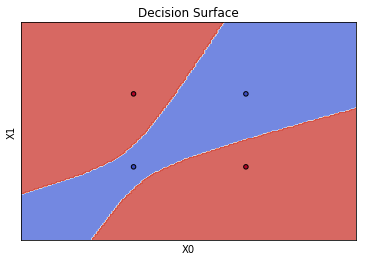

In [6]:
np.random.seed(0)
clf = svm.SVC(kernel='poly', degree=2, C=15)
clf.fit(X, y)
plot_decision(X, y, clf)

En este caso, tenemos que las features en el espacio implícito van a ser algo así como:

$$(t_1 X_0, t_2 X_1, t_3 X_0 X_1, t_4 X_0^2, t_5 X_1^2)$$

con las $t$s unas constantes.

Ejercicio: ver que tomando esas features, un SVM con kernel lineal resuelve el problema.

# Manejo de múltiples clases

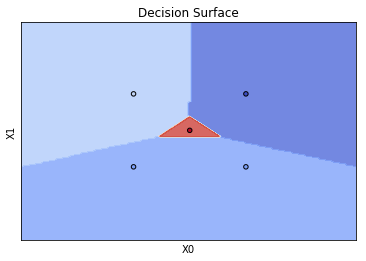

In [7]:
X = [[1, 1],
     [1, 0],
     [0, 1],
     [0, 0],
     [0.5, 0.5]]
y = [0, 1, 2, 1, 5]

np.random.seed(0)
clf = svm.LinearSVC(C=100)
clf.fit(X, y)
plot_decision(X, y, clf)

Queda claro mirando el gráfico que está utilizando la regla del máximo

# RBFs

## Aprendiendo Ruido

Para este ejemplo, generamos ruido distribuido uniformemente en el cuadrado $[0, 1] \times [0, 1]$, y le asignamos clases de manera aleatoria.

Luego, entrenamos un SVM usando RBF con un $\gamma$ muy alto (mucha granularidad), y un $C$ muy alto también (dándole mucha importancia a los elementos del lado erróneo del márgen).  

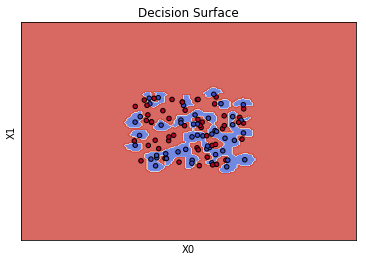

In [8]:
N = 100

np.random.seed(0)
X = np.random.rand(N, 2)
y = np.random.randint(2, size=N)
clf = svm.SVC(kernel='rbf', gamma=1000, C=100000)
clf.fit(X, y)
plot_decision(X, y, clf)

Queda claro que estamos en un severo caso de overfitting. Los parámetros que elegímos son lo suficientemente fuertes como para lograrlo. Además, si miramos la cantidad de vectores de soporte:

In [9]:
clf.n_support_

array([49, 50])

Es muy claro que básicamente tomamos a todo el conjunto de datos como vectores de soporte. Esto es, en efecto, un indicador de que no aprendimos nada.

## Mixtura de Gaussianas

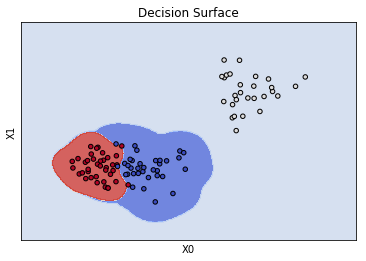

In [10]:
N = 100
M = [
    ([0, 0], 0.1 * np.identity(2)),
    ([2, 2], 0.2 * np.identity(2)),
    ([-1, 0], 0.1 * np.identity(2))
]
P = [0.3, 0.3, 0.4]
assert len(P) == len(M)

np.random.seed(0)
X = []
y = []
for i in np.random.choice(len(P), size=N, replace=True, p=P):
    X.append(np.random.multivariate_normal(mean=M[i][0], cov=M[i][1]))
    y.append(i)
X = np.array(X)
y = np.array(y)

clf = svm.SVC(kernel='rbf', gamma=10, C=1)
clf.fit(X, y)
plot_decision(X, y, clf)

## Resistencia al Ruido

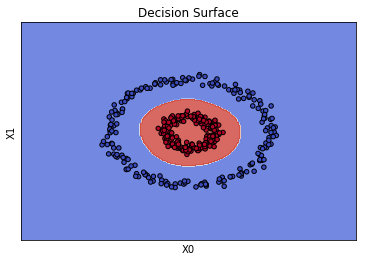

In [11]:
from sklearn.datasets import make_circles

np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

clf = svm.SVC(kernel='rbf', gamma=10, C=1)
clf.fit(X, y)
plot_decision(X, y, clf)

In [12]:
clf.n_support_

array([35, 10])

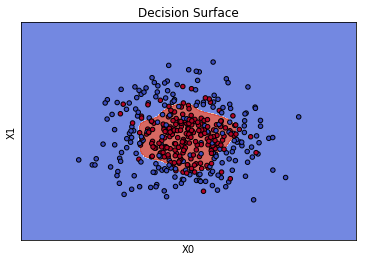

In [13]:
np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.4)

clf = svm.SVC(kernel='rbf', gamma=10, C=1)
clf.fit(X, y)
plot_decision(X, y, clf)

In [14]:
clf.n_support_

array([130, 105])